In [ ]:
main_path='/content/drive/MyDrive/deep learning'
train_data_path=main_path+'/Google_Stock_Price_Train.xls'
test_data_path=main_path+'/Google_Stock_Price_Test.xls'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
train_data=pd.read_csv(train_data_path)
test_data=pd.read_csv(test_data_path)

In [ ]:
train_data.head(2)

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


In [ ]:
train_data['Date'],test_data["Date"]=pd.to_datetime(train_data['Date']),pd.to_datetime(test_data['Date'])

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   object        
 5   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 59.1+ KB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 1.1+ KB


In [ ]:
#there is issue with volumne data having , in its string
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(float)
train_data['Close']=train_data['Close'].str.replace(",",'').astype(float)


train_data['Volume'] = pd.to_numeric(train_data['Volume'])
test_data['Volume'] = pd.to_numeric(test_data['Volume'])

In [ ]:
train_data['Volume'].isna().sum()
test_data['Volume'].isna().sum()

0

In [ ]:
train_data.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


In [ ]:
test_data.head(3)

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,1657300.0
1,2017-01-04,788.36,791.34,783.16,786.90,1073000.0
2,2017-01-05,786.08,794.48,785.02,794.02,1335200.0


In [ ]:
train_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.1 KB


In [ ]:
features_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume']
# Scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[features_to_scale])

https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

In [ ]:
def convert_data_into_array_of_days(input_data, N, M, feature_idx=None):
    X, y = [], []
    for i in range(len(input_data) - N - M + 1):
        # Append the sequences for N days
        X.append(input_data[i:i+N])  # N timesteps

        if feature_idx is not None:
            # Append the target values for the selected feature
            y.append(input_data[i+N:i+N+M, feature_idx])  # M timesteps
        else:
            # Append the target values for all features
            y.append(input_data[i+N:i+N+M])  # M time step

    return np.array(X), np.array(y)

In [1]:

N, M = 30, 1  # 30 days input 1 day prediction
feature_idx = 0  # Predicting Open price

In [ ]:
X_open, y_open = convert_data_into_array_of_days(scaled_train, N, M, feature_idx)

print(f"X_open shape: {X_open.shape}")  # (samples, 30, 5)
print(f"y_open shape: {y_open.shape}")  # (samples, 1)

X_open shape: (1228, 30, 5)
y_open shape: (1228, 1)


In [ ]:
# validation set data for Open price
X_open_train, X_open_val, y_open_train, y_open_val = train_test_split(
    X_open, y_open, test_size=0.2, random_state=42
)


print(f"X_open_train shape: {X_open_train.shape}, X_open_val shape: {X_open_val.shape}")
print(f"y_open_train shape: {y_open_train.shape}, y_open_val shape: {y_open_val.shape}")

X_open_train shape: (982, 30, 5), X_open_val shape: (246, 30, 5)
y_open_train shape: (982, 1), y_open_val shape: (246, 1)


In [ ]:
# lstm_model = Sequential()
# lstm_model.add(LSTM(units=50, return_sequences=True,
#                     input_shape=(X_train.shape[1], X_train.shape[2])))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(LSTM(units=50, return_sequences=True))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(LSTM(units=50, return_sequences=False))
# lstm_model.add(Dropout(0.2))
# lstm_model.add(Dense(units=5))  # Predict the Open, High, Low, Close, Volume of stock
# lstm_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
def lstm_model_body(input_shape):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True,
                   input_shape=input_shape))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=False))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(units=1))  # Predict the Open price of stock
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    return lstm_model


MModel 1: Predict open price

In [ ]:
input_shape = (X_open.shape[1], X_open.shape[2])
lstm_open_price_model = lstm_model_body(input_shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_open_price_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1
)

In [ ]:
model_checkpoints=ModelCheckpoint(
    filepath=main_path+'/lstm_model_open_price.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
# Train the model for Open price
history_open = lstm_open_price_model.fit(
    X_open_train, y_open_train,
    validation_data=(X_open_val, y_open_val),
    epochs=1000,
    batch_size=32,
    callbacks=[model_checkpoints, early_stopping]
)

Epoch 1/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0897
Epoch 1: val_loss improved from inf to 0.00340, saving model to /content/drive/MyDrive/deep learning/lstm_model_open_price.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0882 - val_loss: 0.0034
Epoch 2/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0065
Epoch 2: val_loss improved from 0.00340 to 0.00180, saving model to /content/drive/MyDrive/deep learning/lstm_model_open_price.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 3/1000
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0040
Epoch 3: val_loss improved from 0.00180 to 0.00156, saving model to /content/drive/MyDrive/deep learning/lstm_model_open_price.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 4/1000
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0043
Epoch 4: val_loss improved from 0.00156 to 0.00152, saving model to /content/drive/MyDrive/deep learning/lstm_m

In [ ]:
# Scaling the test data
scaled_test = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])


In [ ]:
N, M = 30, 1  # Use 30 past days to predict 1 day ahead
feature_idx = 0  # Predicting Open price

X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

# Check shapes
print(f"X_test shape: {X_test.shape}")  # (samples, 30, 5)
print(f"y_test shape: {y_test.shape}")  # (samples, 1)

In [ ]:
scaled_test.shape

(20, 5)

In [ ]:
N = min(10, len(scaled_test) - M)
M = 1


X_test, y_test = convert_data_into_array_of_days(scaled_test, N, M, feature_idx=feature_idx)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10, 10, 5)
y_test shape: (10, 1)


In [ ]:
y_pred_scaled_test = lstm_open_price_model.predict(X_test)

# Check predicted shape
print(f"Predicted Test Shape: {y_pred_scaled_test.shape}")  # (samples, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Test Shape: (10, 1)


In [ ]:
feature_idx

0

In [ ]:
y_pred_scaled_test

array([[0.74389017],
       [0.7474388 ],
       [0.7499207 ],
       [0.75193536],
       [0.75290614],
       [0.75354236],
       [0.7551217 ],
       [0.7578647 ],
       [0.7613661 ],
       [0.7639271 ]], dtype=float32)

In [ ]:
# Inverse transform predictions
y_pred_original_test = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_test, np.zeros((y_pred_scaled_test.shape[0], 4))], axis=1)
)[:, feature_idx] # " Open price"

# Inverse transform actual test values
y_test_original = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 4))], axis=1)
)[:, feature_idx]  # Extract the column for the Open price

In [ ]:
compare_table = pd.DataFrame({
    "Actual": y_test_original.flatten(),
    "Predicted": y_pred_original_test.flatten()
})

print(compare_table)

   Actual   Predicted
0  805.81  679.005598
1  805.12  680.913195
2  806.91  682.247385
3  807.25  683.330374
4  822.30  683.852227
5  829.62  684.194233
6  837.81  685.043225
7  834.71  686.517755
8  814.66  688.399976
9  796.86  689.776653


In [ ]:
mse_test = mean_squared_error(y_test_original, y_pred_original_test)
rmse_test = mse_test ** 0.5
mae_test = mean_absolute_error(y_test_original, y_pred_original_test)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")

Test MSE: 17542.703334300597
Test RMSE: 132.44887064184653
Test MAE: 131.77693784666062


In [ ]:
y_test_original.shape, y_pred_original_test.shape

((10,), (10,))

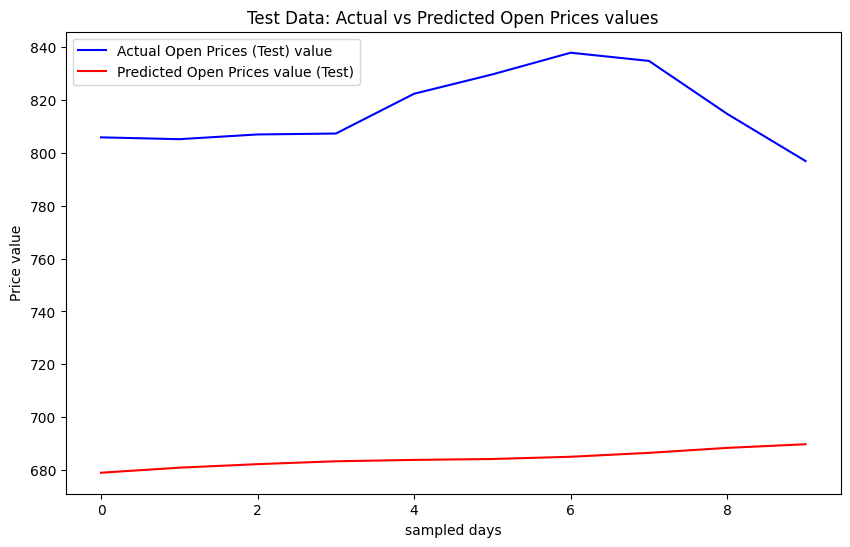

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Open Prices (Test) value", color='blue')
plt.plot(y_pred_original_test, label="Predicted Open Prices value (Test)", color='red')
plt.title("Test Data: Actual vs Predicted Open Prices values")
plt.xlabel("sampled days")
plt.ylabel("Price value")
plt.legend()
plt.show()

Preformance on validation set and train set as well

In [ ]:
def model_eval(y_true_scaled, y_pred_scaled, feature_idx, scaler):
    y_pred_original = scaler.inverse_transform(
        np.concatenate([y_pred_scaled, np.zeros((y_pred_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Inverse transform true values
    y_true_original = scaler.inverse_transform(
        np.concatenate([y_true_scaled, np.zeros((y_true_scaled.shape[0], 4))], axis=1)
    )[:, feature_idx]

    # Calculate metrics
    mse = mean_squared_error(y_true_original, y_pred_original)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true_original, y_pred_original)

    return {"MSE": mse, "RMSE": rmse, "MAE": mae}

In [ ]:
# Predict on training data
y_pred_scaled_train = lstm_open_price_model.predict(X_open_train)

# Predict on validation data
y_pred_scaled_val = lstm_open_price_model.predict(X_open_val)

# Predict on test data
y_pred_scaled_test = lstm_open_price_model.predict(X_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Output of train  {'MSE': 368.49420391609715, 'RMSE': 19.19620285150418, 'MAE': 14.424357329634013}
   Actual   Predicted
0  775.48  790.270306
1  717.06  724.839231
2  438.41  448.500886
3  498.63  459.291342
4  584.99  591.767177
5  581.75  575.542058
6  399.05  405.268475
7  539.92  539.544842
8  528.55  546.693493
9  766.69  763.574036


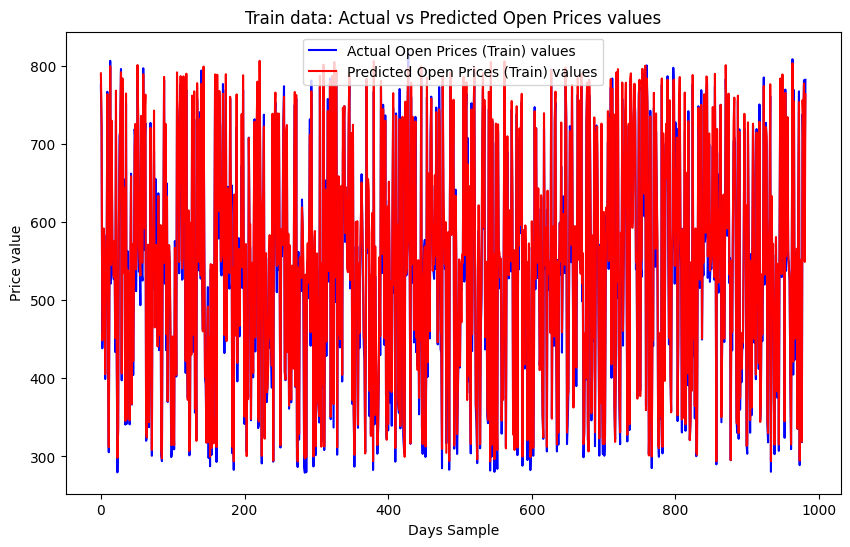

In [ ]:
y_pred_original_train = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_train, np.zeros((y_pred_scaled_train.shape[0], 4))], axis=1)
)[:, feature_idx]

y_train_original = scaler.inverse_transform(
    np.concatenate([y_open_train, np.zeros((y_open_train.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_train=model_eval(y_open_train, y_pred_scaled_train, feature_idx, scaler)
print("Output of train ",outputs_train)

compare_train_table = pd.DataFrame({
    "Actual": y_train_original.flatten(),
    "Predicted": y_pred_original_train.flatten()
})

print(compare_train_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_train_original, label="Actual Open Prices (Train) values", color='blue')
plt.plot(y_pred_original_train, label="Predicted Open Prices (Train) values", color='red')
plt.title("Train data: Actual vs Predicted Open Prices values")
plt.xlabel("Days Sample")
plt.ylabel("Price value")
plt.legend()
plt.show()


Output of validation  {'MSE': 462.65677973871203, 'RMSE': 21.509457913641434, 'MAE': 15.830288969322247}
   Actual   Predicted
0  526.35  547.060748
1  577.83  583.365591
2  378.12  380.738295
3  515.76  543.029933
4  777.85  784.704003
5  595.10  619.650151
6  582.16  578.171701
7  516.64  529.265825
8  287.07  298.404498
9  335.80  331.667223


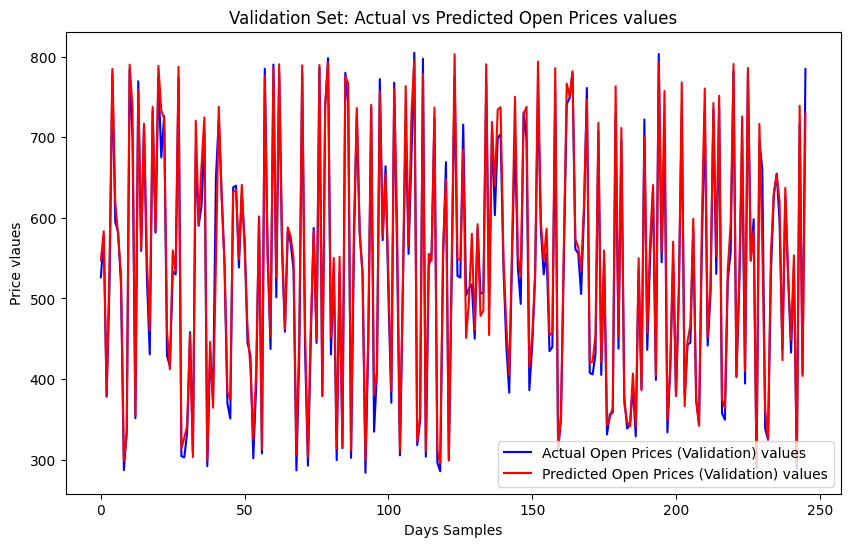

In [ ]:
y_pred_original_val = scaler.inverse_transform(
    np.concatenate([y_pred_scaled_val, np.zeros((y_pred_scaled_val.shape[0], 4))], axis=1)
)[:, feature_idx]

y_val_original = scaler.inverse_transform(
    np.concatenate([y_open_val, np.zeros((y_open_val.shape[0], 4))], axis=1)
)[:, feature_idx]

outputs_val=model_eval(y_open_val, y_pred_scaled_val, feature_idx, scaler)
print("Output of validation ",outputs_val)

compare_val_table = pd.DataFrame({
    "Actual": y_val_original.flatten(),
    "Predicted": y_pred_original_val.flatten()
})

print(compare_val_table.head(10))

plt.figure(figsize=(10, 6))
plt.plot(y_val_original, label="Actual Open Prices (Validation) values", color='blue')
plt.plot(y_pred_original_val, label="Predicted Open Prices (Validation) values", color='red')
plt.title("Validation Set: Actual vs Predicted Open Prices values")
plt.xlabel("Days Samples")
plt.ylabel("Price vlaues")
plt.legend()
plt.show()
